In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Read the files

In [2]:
#read csv file
portfolio = pd.read_csv('../Data/Portfolio.csv',parse_dates=True,index_col='T')


In [3]:
#tranform this into a matrix
X = portfolio.values

#the last column is the target
Y = X[:,-1]

#create the design matrix2
X = X[:,0:-1]

index_name = portfolio.columns[:-1]

Set up the ridge regression (fit_intercept=True, in order to allow normalization to be true)

In [4]:
#setting up the model
Alpha = 0.2
ridge_model = linear_model.Ridge(fit_intercept=True, alpha=Alpha,copy_X=True,normalize=True)
ridge_model.fit(X,Y)

Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None, normalize=True,
      random_state=None, solver='auto', tol=0.001)

In [5]:
ridge_model.coef_

array([ 0.06875051,  0.35039763,  0.3661553 ,  0.09120387,  0.12143333,
       -0.06298251,  0.22549215])

In [6]:
ols_model = linear_model.LinearRegression(fit_intercept=True)
ols_model.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
print('RSquared OLS')
print(ols_model.score(X,Y))
print('RSquared Ridge')
print(ridge_model.score(X,Y))

RSquared OLS
0.5721537153344336
RSquared Ridge
0.560088140164718


In [8]:
#using the function to estimate the portfolio return
X_test = np.array([0.01 , 0.01, 0.02 , -0.05 , 0.0, 0.01,0.07])
X_test = X_test.reshape((1,len(X_test)))

Y_test = ols_model.predict(X_test)
print(Y_test)

[0.04550743]


Gross Exposure OLS :205.76

Gross Exposure Ridge :128.64



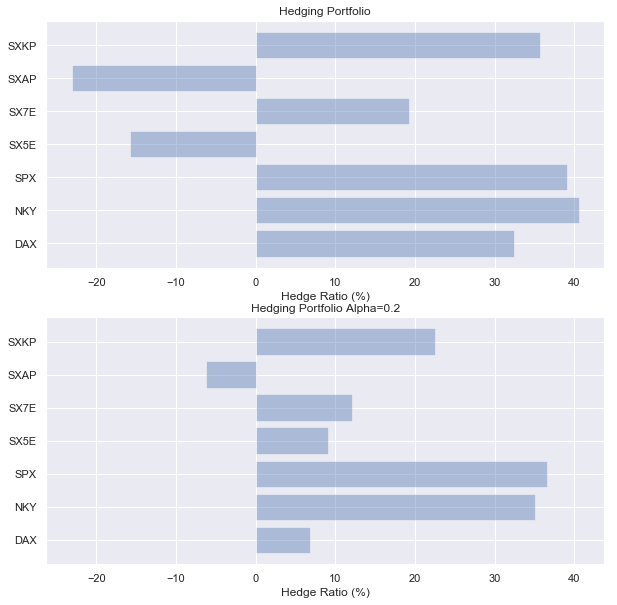

In [9]:
#OLS
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)

y_pos = np.arange(len(index_name))
hedge_ols = ols_model.coef_
plt.barh(y=y_pos, width=hedge_ols*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio')
xmin, xmax = plt.xlim() 
print('Gross Exposure OLS :{d:0.2f}\n'.format(d=100*np.sum(np.abs(hedge_ols))))


#Ridge Regression
plt.subplot(2,1,2)
hedge_ridge = ridge_model.coef_
plt.barh(y=y_pos, width=hedge_ridge*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio Alpha='+ str(Alpha))
plt.xlim([xmin,xmax])
print('Gross Exposure Ridge :{d:0.2f}\n'.format(d=100*np.sum(np.abs(hedge_ridge))))




Study the impact of the ridge regression on the weights

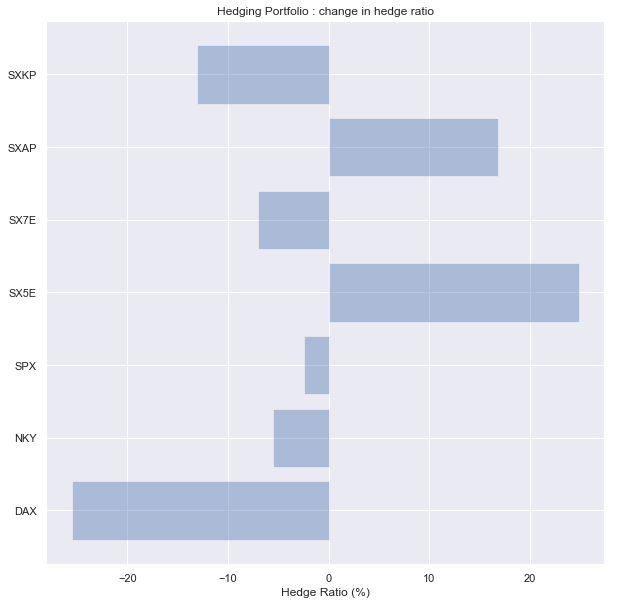

In [10]:
plt.figure(figsize=(10,10))
plt.barh(y=y_pos, width=(hedge_ridge-hedge_ols)*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio : change in hedge ratio');

For different values of Alpha

In [12]:
alpha = np.power(10,np.arange(-2,0,0.005))

In [13]:
weights = np.zeros((len(alpha),len(index_name)),dtype=float)

In [14]:
for i in np.arange(0,len(alpha)):
    ridge_model = linear_model.Ridge(fit_intercept=True, alpha=alpha[i],copy_X=True,normalize=True)
    ridge_model.fit(X,Y)
    weights[i,:]= ridge_model.coef_
    

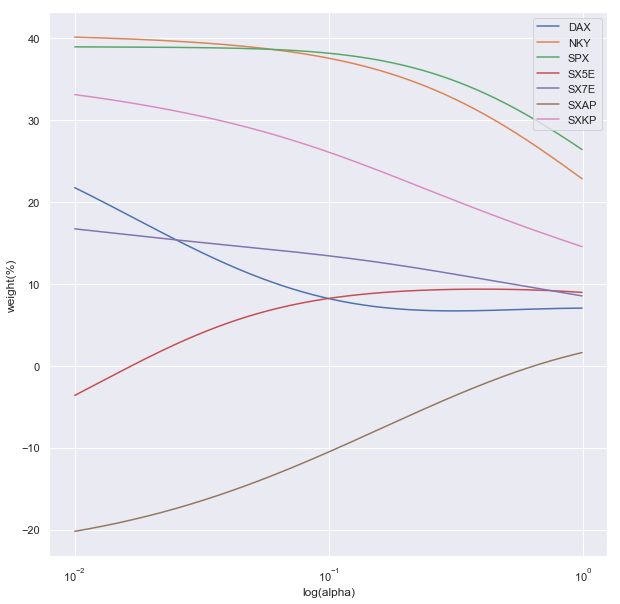

In [15]:
plt.figure(figsize=(10,10))    
for i in np.arange(0,len(index_name)):
    plt.semilogx(alpha[:],weights[:,i]*100,label=index_name[i])

plt.xlabel('log(alpha)')
plt.ylabel('weight(%)')
plt.legend(loc="upper right");
    

Using cross validation to find the optimal value of the ridge factor.

In [16]:
# use cross validation using 10 Fold cross validation
Ridge=linear_model.RidgeCV(alphas=alpha,fit_intercept=True,normalize=True,cv=10)
Ridge.fit(X,Y)
print('Optimal Value for Alpha:{v:0.4f}'.format(v=Ridge.alpha_))
print(Ridge.coef_)

Optimal Value for Alpha:0.5248
[ 0.06837724  0.28699529  0.31603679  0.09317992  0.09973526 -0.00919535
  0.17523091]


/Users/jandespiegeleer/.pyenv/versions/3.7.0/envs/my_3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [17]:
print('Gross',np.round(np.sum(np.abs(Ridge.coef_)),2))

Gross 1.05


(-26.300326989847285, 43.74956999876691)

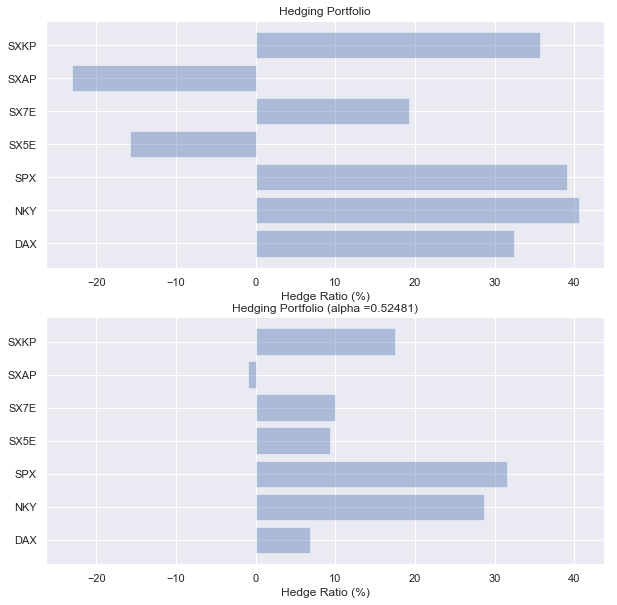

In [18]:
#calc with new alpha
ridge_model = linear_model.Ridge(fit_intercept=True, alpha=Ridge.alpha_,copy_X=True,normalize=True)
ridge_model.fit(X,Y)


#OLS
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
y_pos = np.arange(len(index_name))
hedge_ols = ols_model.coef_
plt.barh(y=y_pos, width=hedge_ols*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio')
xmin, xmax = plt.xlim() 

#Optimal Ridge Regression
plt.subplot(2,1,2)
hedge_ridge = ridge_model.coef_
plt.barh(y=y_pos, width=ridge_model.coef_*100, align='center', alpha=0.4)
plt.yticks(y_pos, index_name)
plt.xlabel('Hedge Ratio (%)')
plt.title('Hedging Portfolio (alpha =%5.5f)' % Ridge.alpha_ )
plt.xlim([xmin,xmax])